# Chapter 17. 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

# 기본 설정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version은 코랩에서만 동작합니다.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# 17.1 효율적인 데이터 표현

### 오토인코더(autoencoder)  
어떤 지도 없이도(=레이블이 없는 훈련 데이터를 사용해서) **잠재 표현(latent representation)** 또는 **코딩(coding)**이라 불리는 입력 데이터의 밀집 표현을 학습할 수 있는 인공 신경망  

오토인코더의 작동방식  
- 오토인코더는 단순히 입력을 출력으로 복사하는 방법을 배움(이때, 다양한 방법으로 네트워크에 제약을 가해 이 작업을 어렵게 만듦)  
    - 네트워크에 제약을 가하는 방법: 잠재 표현의 크기를 제한, 입력에 잡음을 추가하고 원본 입력을 복원하도록 네트워크를 훈련 등  
- 이런 제약은 오토인코더가 단순히 입력을 출력으로 바로 복사하지 못하도록 막고 **데이터를 효율적으로 표현하는 방법**을 배우게 만듦  
- 즉 **"코딩(coding) = 일정 제약 조건하에서 항등 함수(identity function)를 학습하려는 오토인코더의 노력으로 생겨난 부산물"** 이라고 볼 수 있음

### 생성적 적대 신경망(GAN, Generative Adversarial Networks)  
대표적인 비지도 학습(unsupervised learning)의 한 종류로 **서로 대립하는 두 시스템이 서로 경쟁하는 방식**으로 학습이 진행됨  

GAN의 작동방식
- GAN은 신경망 두 개로 구성됨(생성자, 판별자)  
    - **생성자(generator)**: 훈련 데이터와 비슷하게 보이는 데이터를 생성, "위조 지폐를 만드는 범인"으로 비유됨  
    - **판별자(discriminator)**: 가짜 데이터와 진짜 데이터를 구별, "가짜와 진짜 지폐를 구별하는 경찰관"으로 비유됨  
- 위 구조는 신경망이 훈련하는 동안 생성자와 판별자가 서로 경쟁한다는 점에서 매우 새로움, 이렇게 경쟁하는 신경망을 훈련하는 것을 **적대적 훈련(adversarial training)**이라고 함  


`오토인코더와 GAN은 모두 비지도 학습이며, 둘 다 밀집 표현을 학습하고, 생성 모델로 사용할 수 있다는 공통점이 있음`  

# 17.2 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋 생성:

In [3]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

오토인코더 생성:

In [4]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [5]:
# 오토인코더 훈련

history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 6ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 6ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 7ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 7ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 6ms/step - loss: 0.

In [6]:
# 동일한 데이터셋을 인코딩

codings = encoder.predict(X_train)

2/2 [==============================] - 0s 5ms/step


그림 저장 linear_autoencoder_pca_plot


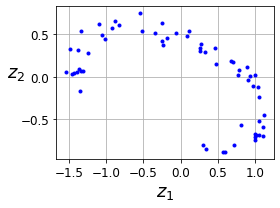

In [7]:
# 오토인코더의 은닉층 출력 시각화

fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

# 17.3 적층 오토인코더

**적층 오토인코더**: 은닉층을 여러 개 가진 오토인코더

In [8]:
# MNIST 데이터셋 다운

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


## 17.3.1 케라스를 사용하여 적층 오토인코더 구현하기

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더 생성:

In [9]:
# 반올림 함수

def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(X_train, X_train, epochs=20,
                         validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3172 - val_rounded_accuracy: 0.8990
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3056 - rounded_accuracy: 0.9151 - val_loss: 0.3020 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2987 - val_rounded_accuracy: 0.9196
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [==================

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리함  
그런 다음 원본 이미지와 재구성 이미지를 그림:

# 17.3.2 재구성 시각화

오토인코더가 적절히 훈련되었는지 확인하는 한 가지 방법: 입력과 출력을 비교한 후 입력과 출력의 차이가 너무 크지 않는지 확인

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 58ms/step
그림 저장 reconstruction_plot


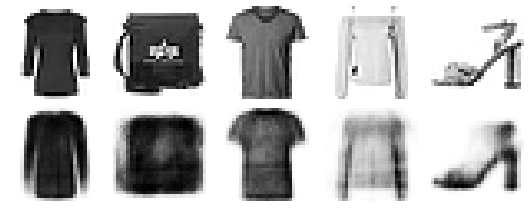

In [12]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

## 17.3.3 패션 MNIST 데이터셋 시각화

In [13]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 1ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


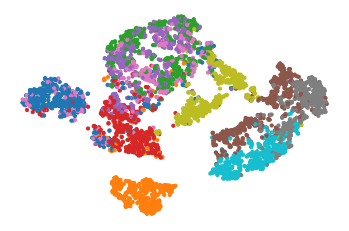

In [14]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

위 그림을 좀더 예쁘게 그려보면 아래와 같음:

그림 저장 fashion_mnist_visualization_plot


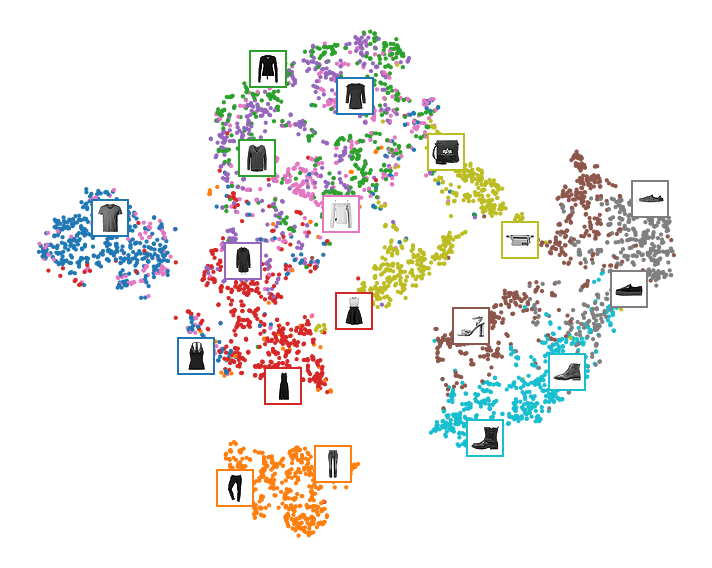

In [15]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

## 17.3.4 적층 오토인코더를 사용한 비지도 사전훈련

- 대부분 레이블이 없는 대량의 데이터셋이 있다면 먼저 전체 데이터를 사용해 적층 오토인코더를 훈련시킴  
- 그다음 오토인코더의 하위층을 재사용해 실제 문제를 해결하기 위한 신경망을 만들고 레이블된 데이터를 사용해 훈련할 수 있음  
- 분류기를 훈련할 때 레이블된 훈련 데이터가 많지 않으면 사전훈련된 층을 동결하는 것이 좋음

## 17.3.5 가중치 묶기

인코더의 가중치를 전치(transpose)하여 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔함  
이렇게 하려면 사용자 정의 층을 사용해야 함:

In [16]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3081 - val_rounded_accuracy: 0.9079
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9223 - val_loss: 0.2951 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3020 - val_rounded_accuracy: 0.9082
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9324 - val_loss: 0.2874 - val_rounded_accuracy: 0.9313
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9353
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 65ms/step


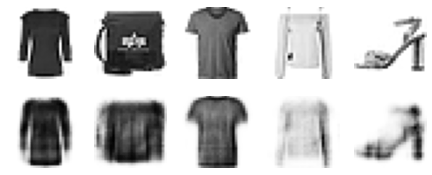

In [18]:
show_reconstructions(tied_ae)
plt.show()

## 17.3.6 한 번에 오토인코더 한 개씩 훈련하기

In [19]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, X_train_flat, X_valid_flat, "binary_crossentropy",
    keras.optimizers.SGD(learning_rate=1.5), output_activation="sigmoid",
    metrics=[rounded_accuracy])
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(learning_rate=0.05),
    output_activation="selu")

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [21]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

1/1 [==============================] - 0s 56ms/step


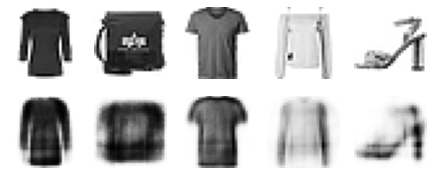

In [22]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [23]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9350
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 58ms/step


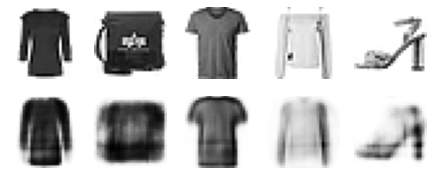

In [24]:
# 최종 재구성 이미지 출력

show_reconstructions(stacked_ae_1_by_1)
plt.show()

# 17.4 합성곱 오토인코더

**합성곱 오토인코더**: 합성곱 층과 풀링 층으로 구성된 인코더와 전치 합성곱 층으로 구성된 디코더를 사용하는 오토인코더

합성곱 오토인코더 생성:

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 5ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2850 - val_rounded_accuracy: 0.9284
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2756 - rounded_accuracy: 0.9414 - val_loss: 0.2729 - val_rounded_accuracy: 0.9457
Epoch 3/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2697 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2682 - rounded_accuracy: 0.9490 - val_loss: 0.2685 - val_rounded_accuracy: 0.9493
Epoch 5/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2664 - rounded_accuracy: 0.9510 - val_loss: 0.2670 - val_rounded_accuracy: 0.9511


In [26]:
# 모델 구조 요약

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 196ms/step


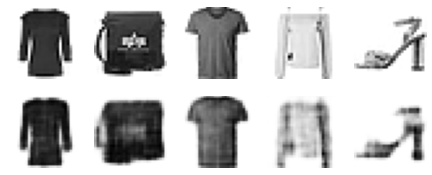

In [27]:
# 최종 재구성 이미지 출력

show_reconstructions(conv_ae)
plt.show()

# 17.5 순환 오토인코더

**순환 오토인코더**: 시퀀스-투-벡터 RNN으로 구성된 인코더와 벡터-투-시퀀스 RNN으로 구성된 디코더를 사용하는 오토인코더

- 과소완전 오토인코더: 입력보다 작은 코딩 층을 구성한 오토인코더
- 과대완전 오토인코더: 입력보다 큰 코딩 층으로 구성한 오토인코더

순환 오토인코더 생성:

In [28]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

In [29]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 21s 10ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4050 - rounded_accuracy: 0.8432 - val_loss: 0.3744 - val_rounded_accuracy: 0.8681
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3604 - val_rounded_accuracy: 0.8765
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3508 - rounded_accuracy: 0.8809 - val_loss: 0.3523 - val_rounded_accuracy: 0.8773
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3406 - rounded_accuracy: 0.8875 - val_loss: 0.3361 - val_rounded_accuracy: 0.8923
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3305 - val_rounded_accuracy: 0.8965
Epoch 7/10
1719/1719 [===========

1/1 [==============================] - 1s 901ms/step


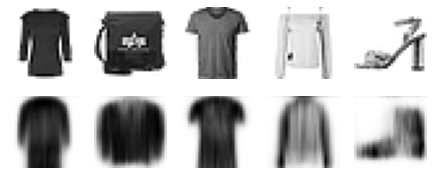

In [30]:
# 최종 재구성 이미지 출력

show_reconstructions(recurrent_ae)
plt.show()

# 17.6 잡음 제거 오토인코더

**적층 잡음 제거 오토인코더**: 오토인코더가 유용한 특성을 학습하도록 강제하기 위해 입력에 잡음을 추가하고, 잡음이 없는 원본 입력을 복원하도록 훈련한 오토인코더

가우시안 잡음을 사용한 잡음 제거 오토인코더:

In [31]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9217
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9238
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 59ms/step


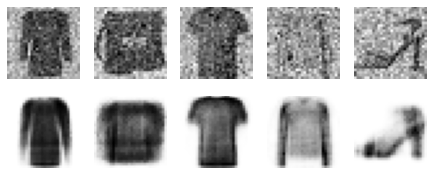

In [32]:
# 가우시안 잡음 오토인코더의 재구성 이미지 출력

tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

드롭아웃을 사용한 잡음 제거 오토인코더:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 57ms/step
그림 저장 dropout_denoising_plot


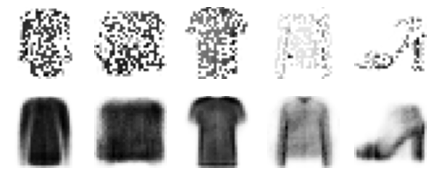

In [34]:
# 드롭아웃 오토인코더의 재구성 이미지 출력

tf.random.set_seed(42)
np.random.seed(42)

dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
save_fig("dropout_denoising_plot", tight_layout=False)

# 17.7 희소 오토인코더

**희소 오토인코더**: 비용 함수에 적절한 항을 추가하여 오토인코더가 코딩 층에서 활성화되는 뉴런 수를 감소시키는 제약 방식인 "희소"를 사용하는 오토인코더

간단한 적층 오토인코더를 만들어 희소 오토인코더와 비교하겠음  
이번에는 코딩 층에 시그모이드 활성화 함수를 사용하여 코딩 값의 범위가 0~1 사이가 되도록 만듦:

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 71ms/step


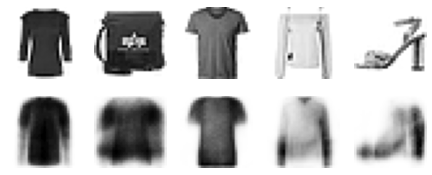

In [36]:
show_reconstructions(simple_ae)
plt.show()

활성화 히스토그램을 출력하기 위한 함수 정의:

In [37]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [38]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

이 함수를 사용해 인코딩 층의 활성화에 대한 히스토그램을 출력:

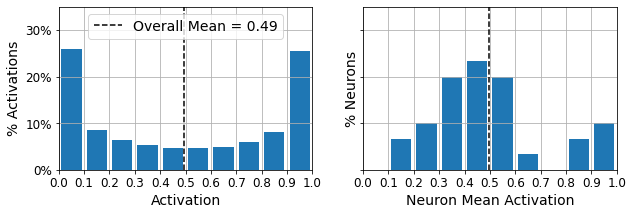

In [39]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

<히스토그램 해석>  
왼쪽
- 왼쪽의 히스토그램은 전체 활성화의 분포를 보여줌  
- 0과 1에 가까운 값이 전체적으로 더 많이 등장하는데, 이는 시그모이드 함수가 포화되는 특성 때문임  

오른쪽
- 오른쪽의 히스토그램은 평균 뉴런의 분포를 보여줌  
- 대부분의 뉴런이 0.5에 가까운 평균 활성화를 가지고 있음  

종합
- 두 히스토그램은 각 뉴런이 50% 확률로 0이나 1에 가까운 값에 활성화된다는 것을 보여주고 있음  
- 하지만 일부 뉴런은 거의 항상 활성화됨(오른쪽 히스토그램의 오른쪽편)

코딩 층에 $\ell_1$ 규제를 추가:

In [40]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])

history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 65ms/step


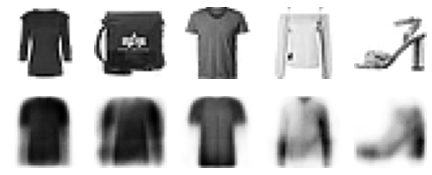

In [41]:
# 재구성 이미지 출력

show_reconstructions(sparse_l1_ae)

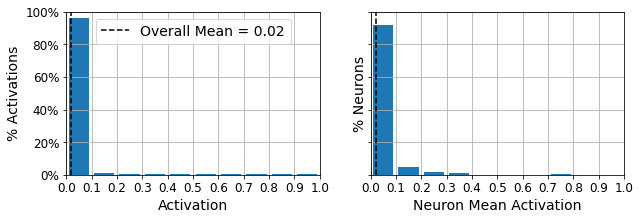

In [43]:
# 인코딩 층의 활성화에 대한 히스토그램을 출력

plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

희소성을 위해 KL 발산을 사용하여 0% 아니라 10% 희소성을 생성:

그림 저장 sparsity_loss_plot


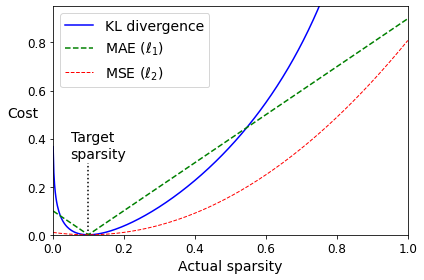

In [42]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [44]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

KL 발산을 사용한 오토인코더 생성:

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])

history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 81ms/step


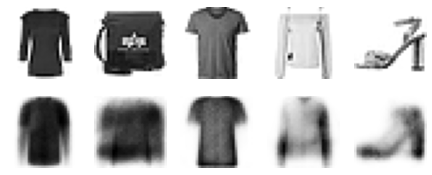

In [46]:
# 재구성 이미지 출력

show_reconstructions(sparse_kl_ae)

그림 저장 sparse_autoencoder_plot


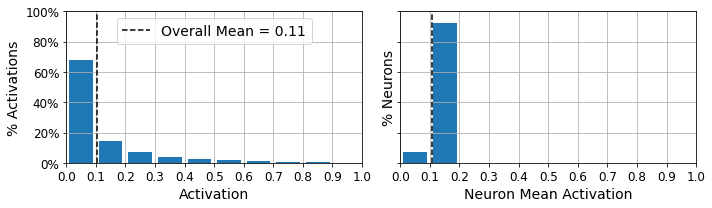

In [47]:
# 인코딩 층의 활성화에 대한 히스토그램을 출력

plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

# 17.8 변이형 오토인코더

**변이형 오토인코더**는 지금까지 다룬 오토인코더와 매우 다름  

<특징>  
- **확률적 오토인코더**임, 즉 훈련이 끝난 후에도 출력이 부분적으로 우연에 의해 결정됨(이전에 본 잡음 제거 오토인코더는 훈련 시에만 무작위성을 사용했음)  
- **생성 오토인코더**임, 마치 훈련 세트에서 샘플링된 것 같은 새로운 샘플을 생성할 수 있음

In [48]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 4s 6ms/step - loss: 0.3895 - rounded_accuracy: 0.8609 - val_loss: 0.3535 - val_rounded_accuracy: 0.8845
Epoch 2/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3424 - rounded_accuracy: 0.8982 - val_loss: 0.3387 - val_rounded_accuracy: 0.9013
Epoch 3/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3326 - rounded_accuracy: 0.9054 - val_loss: 0.3348 - val_rounded_accuracy: 0.9040
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3269 - val_rounded_accuracy: 0.9121
Epoch 5/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3248 - rounded_accuracy: 0.9118 - val_loss: 0.3273 - val_rounded_accuracy: 0.9149
Epoch 6/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3226 - rounded_accuracy: 0.9137 - val_loss: 0.3258 - val_rounded_accuracy: 0.9140
Epoch 7/25
430/430 [==============================] 

1/1 [==============================] - 0s 119ms/step


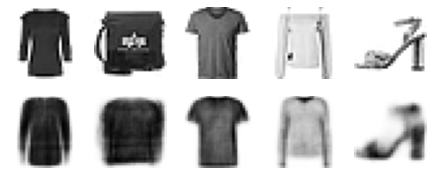

In [50]:
# 최종 재구성 이미지 출력

show_reconstructions(variational_ae)
plt.show()

## 17.8.1 패션 MNIST 이미지 생성하기

여러 이미지를 출력하는 함수 정의:

In [51]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

몇 개의 랜덤한 코딩을 생성하고 이를 디코딩하여 결과 이미지를 출력:

그림 저장 vae_generated_images_plot


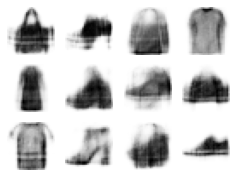

In [52]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

이미지 사이에서 의미 보간을 수행:

그림 저장 semantic_interpolation_plot


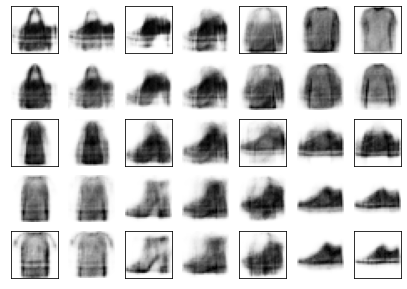

In [53]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
save_fig("semantic_interpolation_plot", tight_layout=False)

# 17.9 생성적 적대 신경망

**생성자**  
- 랜덤한 분포를 입력으로 받고 이미지와 같은 데이터를 출력  
- 생성자는 변이형 오토인코더의 디코더와 같은 기능을 제공  

**판별자**  
- 생성자에서 얻은 가짜 이미지나 훈련 세트에서 추출한 진짜 이미지를 입력으로 받아 입력된 이미지가 가짜인지 진짜인지 구분  
- 판별자는 진짜 이미지와 가짜 이미지를 구분하고 생성자는 판별자를 속일 만큼 진짜 같은 이미지를 만듦  

`GAN은 첫번째 단계에서 판별자를 훈련하고, 두번째 단계에서 생성자를 훈련함`


생성자, 판별자 생성:

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

모델 컴파일:

In [55]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

이미지를 순회하는 dataset 생성:

In [56]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

사용자 정의 훈련 반복문 정의(훈련이 일반적인 반복이 아니기 때문에 `fit()` 메서드 사용 불가):

In [57]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:
            # 1단계 - 판별자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            
            # 2단계 - 생성자 훈련
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)
        plt.show()

생성된 이미지 출력:

Epoch 1/1


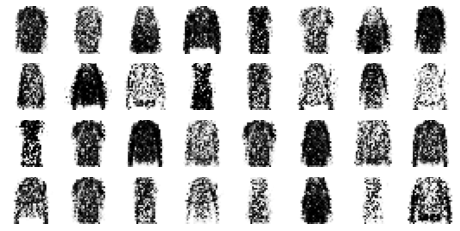

In [58]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

그림 저장 gan_generated_images_plot


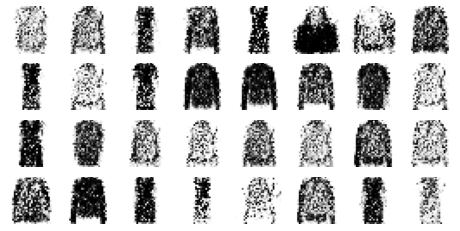

In [59]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("gan_generated_images_plot", tight_layout=False)

In [ ]:
# 너무 오래 걸려서 주석처리함, 확인하고 싶으면 주석제거 후 확인

#train_gan(gan, dataset, batch_size, codings_size)

## 17.9.1 GAN 훈련의 어려움

핸즈온 머신러닝 2판 p.705, 706 설명 참조

## 17.9.2 심층 합성곱 GAN

**심층 합성곱 GAN**: 안정적인 합성곱 GAN을 구축하기 위한 연구 끝에 만들어진 GAN  

In [60]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [61]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [62]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [63]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/1


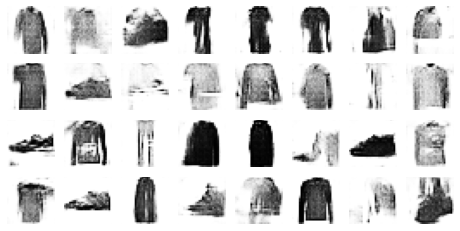

In [64]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

In [ ]:
# 너무 오래 걸려서 주석처리함, 확인하고 싶으면 주석제거 후 확인

#train_gan(gan, dataset, batch_size, codings_size)

그림 저장 dcgan_generated_images_plot


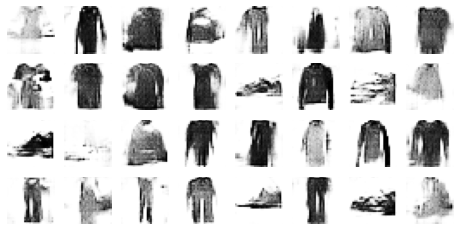

In [65]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

# 추가 자료

## 이진 오토인코더를 사용한 해싱

패션 MNIST 데이터셋 다시 로드:

In [66]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

인코더의 출력 층이 시그모이드 활성화 함수와 16개의 뉴런을 가지고 있고 가우시안 잡음이 그 앞에 놓인 오토인코더를 훈련해 보겠음  


훈련하는 동안 잡음 층이 이전 층이 큰 값을 출력하도록 학습시킴. 작은 값은 잡음에 묻히기 때문.  
결국 시그모이드 활성화 함수 덕분에 출력층은 0~1 사이의 값을 출력함. 출력값을 0과 1로 반올림하면 16비트 "시맨틱" 해시를 얻음.  


모든 것이 잘 수행되면 비슷한 이미지는 같은 해시를 가지게 될 것임. 이는 검색 엔진에 매우 유용함. 예를 들어, 이미지의 시맨틱 해시에 따라 서버에 이미지를 저장하면 같은 서버에는 모두 비슷한 이미지가 저장될 것임. 검색 엔진 사용자가 탐색할 이미지를 전달하면, 검색 엔진이 인코더를 사용해 이 이미지의 해시를 계산하고, 이 해시에 해당하는 서버의 모든 이미지를 빠르게 반환할 수 있음.

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

hashing_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.GaussianNoise(15.),
    keras.layers.Dense(16, activation="sigmoid"),
])
hashing_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[16]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
hashing_ae = keras.models.Sequential([hashing_encoder, hashing_decoder])
hashing_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                   metrics=[rounded_accuracy])
history = hashing_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4055 - rounded_accuracy: 0.8156 - val_loss: 0.3912 - val_rounded_accuracy: 0.8225
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3668 - rounded_accuracy: 0.8500 - val_loss: 0.3677 - val_rounded_accuracy: 0.8429
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3558 - rounded_accuracy: 0.8607 - val_loss: 0.3609 - val_rounded_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3509 - rounded_accuracy: 0.8657 - val_loss: 0.3568 - val_rounded_accuracy: 0.8571
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3479 - rounded_accuracy: 0.8690 - val_loss: 0.3499 - val_rounded_accuracy: 0.8672
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3456 - rounded_accuracy: 0.8713 - val_loss: 0.3447 - val_rounded_accuracy: 0.8765
Epoch 7/10
1719/1719 [==================

오토인코더는 정보를 매우 크게 (16비트로!) 압축하기 때문에 손실이 많지만 이미지를 재구성하려는 것이 아니라 시맨틱 해시를 생성하는 것이 목적이므로 괜찮음:

1/1 [==============================] - 0s 59ms/step


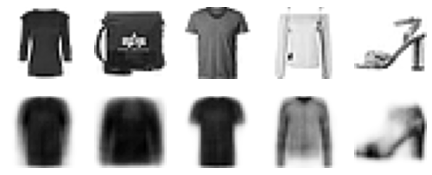

In [68]:
show_reconstructions(hashing_ae)
plt.show()

출력은 0과 1에 매우 가까움(왼쪽 그래프):

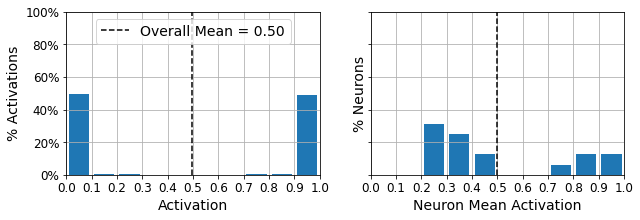

In [69]:
plot_activations_histogram(hashing_encoder)
plt.show()

검증 세트에 있는 처음 몇 개의 이미지에 대한 해시 확인:

In [70]:
hashes = np.round(hashing_encoder.predict(X_valid)).astype(np.int32)
hashes *= np.array([[2**bit for bit in range(16)]])
hashes = hashes.sum(axis=1)
for h in hashes[:5]:
    print("{:016b}".format(h))
print("...")

157/157 [==============================] - 0s 1ms/step
1110100100101000
1000100100101000
1111100100101000
0010101100000000
0000110001010000
...


이제 검증 세트에 있는 이미지 중 가장 많이 등장하는 해시를 찾아 보겠음  
해시마다 몇 개의 샘플을 출력함. 다음 이미지에서 한 행에 있는 이미지는 모두 같은 해시를 가짐

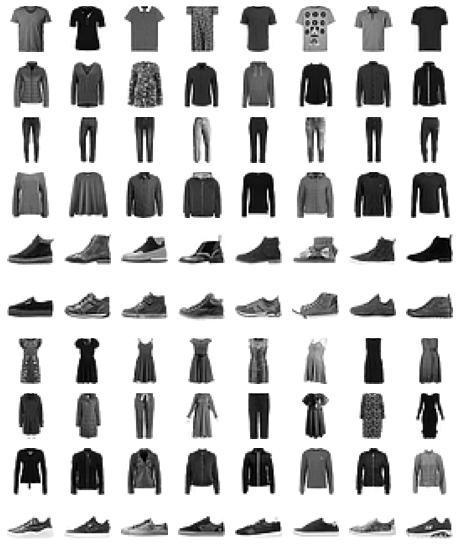

In [71]:
from collections import Counter

n_hashes = 10
n_images = 8

top_hashes = Counter(hashes).most_common(n_hashes)

plt.figure(figsize=(n_images, n_hashes))
for hash_index, (image_hash, hash_count) in enumerate(top_hashes):
    indices = (hashes == image_hash)
    for index, image in enumerate(X_valid[indices][:n_images]):
        plt.subplot(n_hashes, n_images, hash_index * n_images + index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# END